In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def vvv_format(title='', ylabel='', autoscale=False, min=0, max=1, legend=True):

    plt.grid()
    plt.xticks(np.arange(1, 35, 4))

    #plt.title(title, fontsize=14)
    plt.title(title)
    if legend:
        plt.legend()
    plt.xlabel('Session Number')
    if autoscale is False:
        plt.ylim(0, max)
    plt.ylabel(ylabel)
    plt.show()

plt.rcParams['figure.figsize'] = 12, 8
    
fontsize = 20
font = {'family' : 'sans-serif',
    'weight' : 'normal',
    'size'   : fontsize}

matplotlib.rc('font', **font)
matplotlib.rc('lines', lw=6)

COLORS = {
    'CHI': 'tab:blue',
    'MOT': 'tab:orange'
}

In [3]:
%%time 

# load the data

store = pd.HDFStore('ngram-data.h5')
grams = store['ngram_data']
grams = grams[~pd.isnull(grams.ngram)]

CPU times: user 5.5 s, sys: 475 ms, total: 5.97 s
Wall time: 5.97 s


In [4]:
def top_tokens(df):
    chi = top_ten_for_speaker(df, 'CHI')
    mot = top_ten_for_speaker(df, 'MOT')
    shared = len(np.intersect1d(chi.index, mot.index))
    if shared == 0:
        return pd.Series(
        {'chi_shares': 0,
         'mot_shares': 0}
    )
    return pd.Series(
        {'chi_shares': shared / len(chi),
         'mot_shares': shared / len(mot)}
    )

In [5]:
def get_top_types(df):
    counts = df.ngram.value_counts()
    if len(counts) == 0:
        return counts
    
    cutoff = counts[:10][-1]
    return counts[counts >= cutoff]

# observe that in this case we cut off after 10 tokens

test_data = grams[grams.speaker.eq('CHI')].head(100)
test_data.ngram.value_counts()[:10]

that     7
it       7
what     7
's       6
yeah     4
a        4
teddy    3
eat      3
push     3
big      3
Name: ngram, dtype: int64

In [6]:
# but here, since there are other tokens that tie with 3 examples, (in this case only 1, "big")
# we end up with 11 top tokens.

get_top_types(test_data)

that     7
it       7
what     7
's       6
yeah     4
a        4
teddy    3
eat      3
push     3
big      3
I        3
Name: ngram, dtype: int64

# Ratio of Top Tokens to Total Tokens

In [7]:
def top_token_total_token_ratio(df):
    """ df contains only data from a single speaker and session """
    top_types = get_top_types(df)
    return sum(top_types) / len(df)

In [8]:
get_top_types(grams.head(10))

baby    3
it      2
here    1
's      1
n't     1
fit     1
will    1
Name: ngram, dtype: int64

In [9]:
top_token_total_token_ratio(grams.head(10)), top_token_total_token_ratio(grams.head(40))

(1.0, 0.59999999999999998)

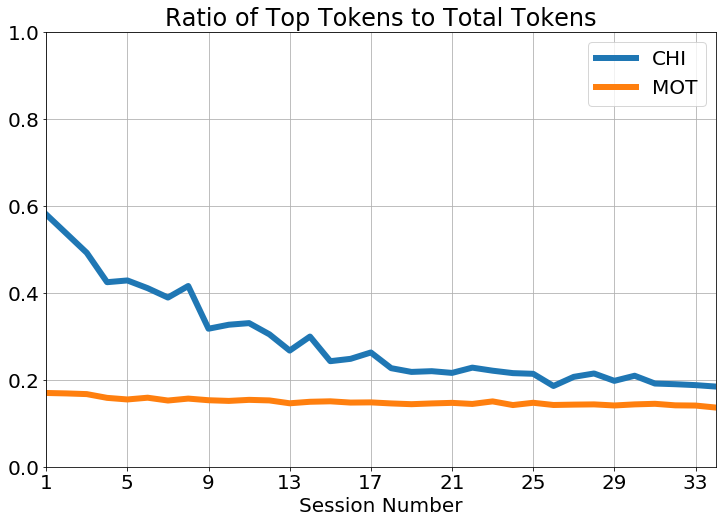

In [10]:
ttr = (
    grams.groupby(['gramsize', 'corpus', 'session', 'speaker'])
    .apply(top_token_total_token_ratio)
)
ttr.unstack('speaker').mean(level='session').plot()
vvv_format(title="Ratio of Top Tokens to Total Tokens")

# Shared Types 1

## How many of the parent's Top Types also exist in the child's Top Types

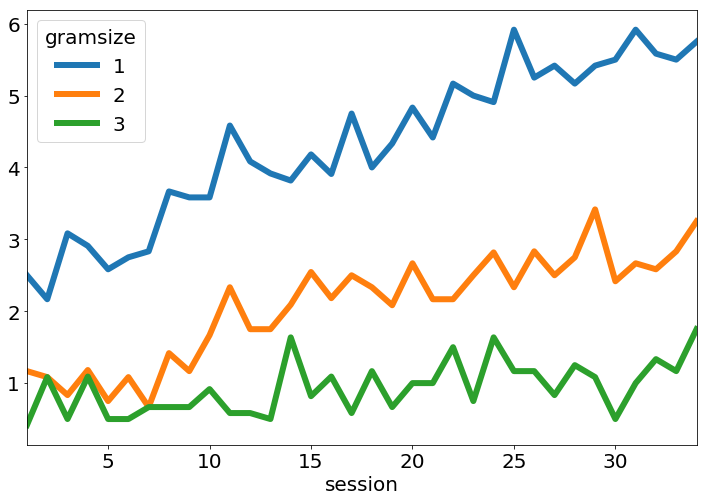

In [46]:
def num_shared_top_types(df):
    """ df contains data from both speakers """
    tops = df.groupby('speaker').apply(get_top_types)
    chi, mot = tops.CHI, tops.MOT
    shared = np.intersect1d(chi.index, mot.index)
    return len(shared)

stt = (
    grams.groupby(['gramsize', 'corpus', 'session'])
    .apply(num_shared_top_types)
)
stt.mean(level=['gramsize', 'session']).unstack('gramsize').plot()
#vvv_format(title="Number of Shared Top Types", legend=False, autoscale=False)

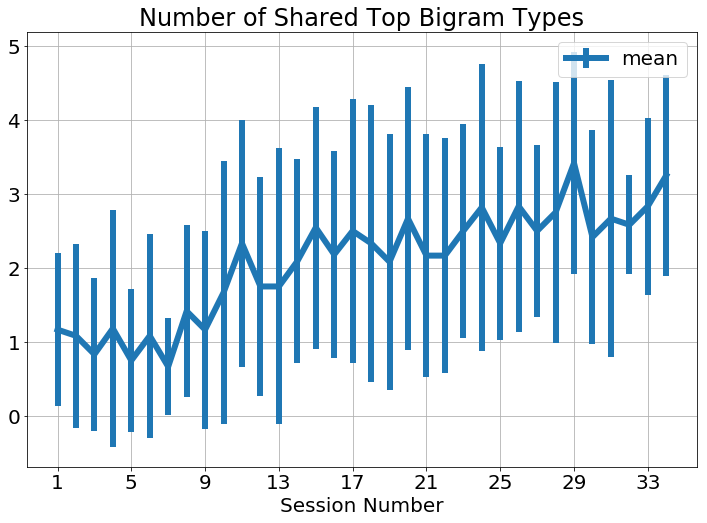

In [129]:
stats = stt[2].groupby(level='session').agg(['mean', 'std'])
plt.errorbar(stats.index, stats['mean'], stats['std']);
vvv_format(autoscale=True, title="Number of Shared Top Bigram Types")

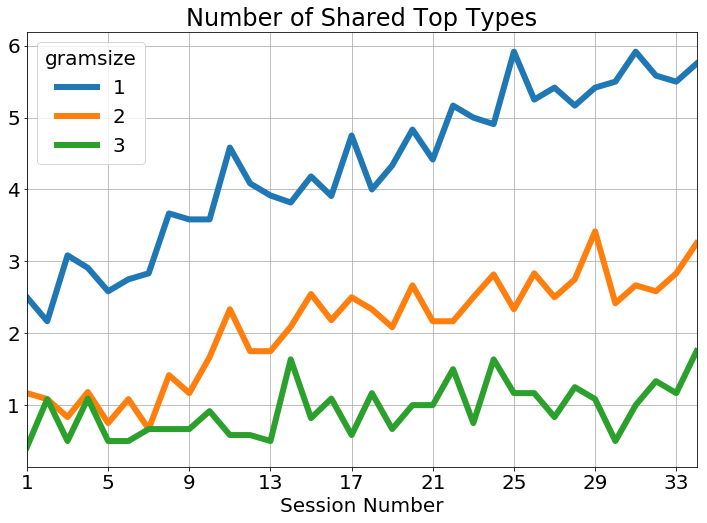

In [49]:
stt.mean(level=['gramsize', 'session']).unstack('gramsize').plot()
vvv_format(title="Number of Shared Top Types", legend=False, autoscale=True)

In [73]:
stt.mean(level='corpus')

corpus
anne     2.960784
aran     2.363636
becky    3.078431
carl     2.959596
domin    2.490196
gail     2.264706
joel     2.950980
john     2.687500
liz      2.313725
nic      1.382353
ruth     0.717172
warr     3.127451
dtype: float64

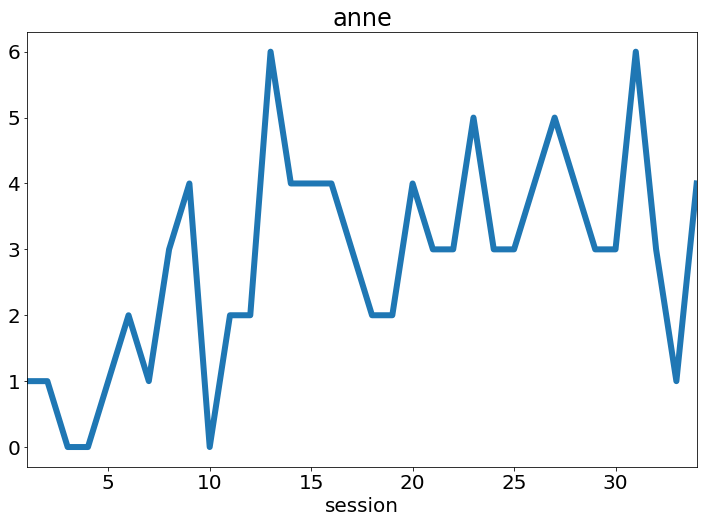

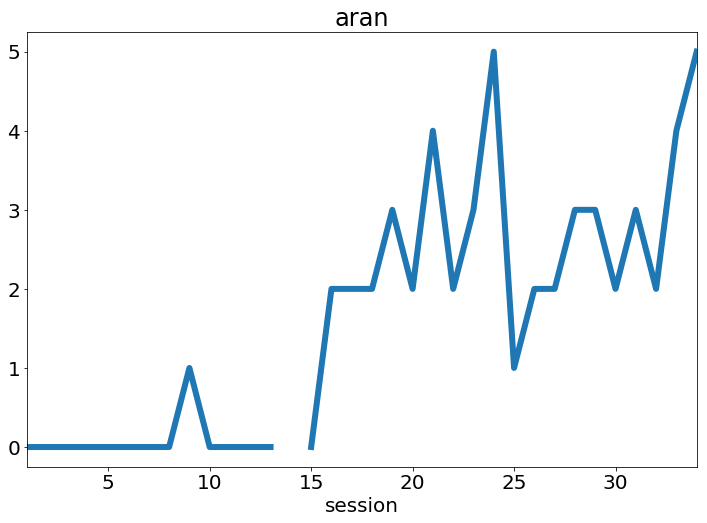

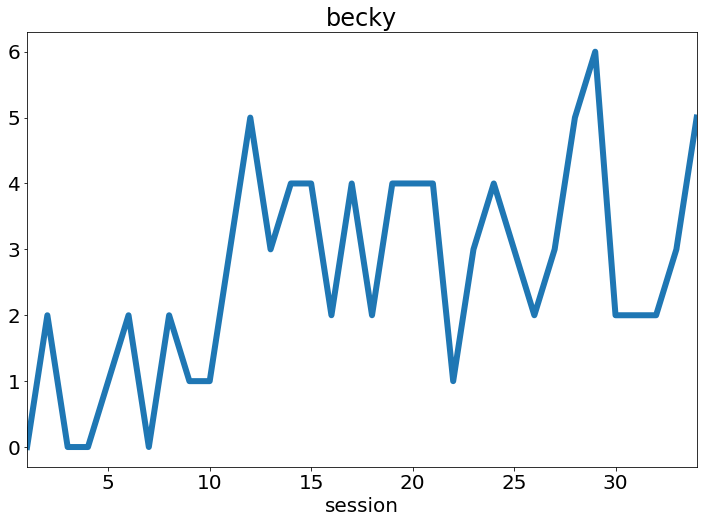

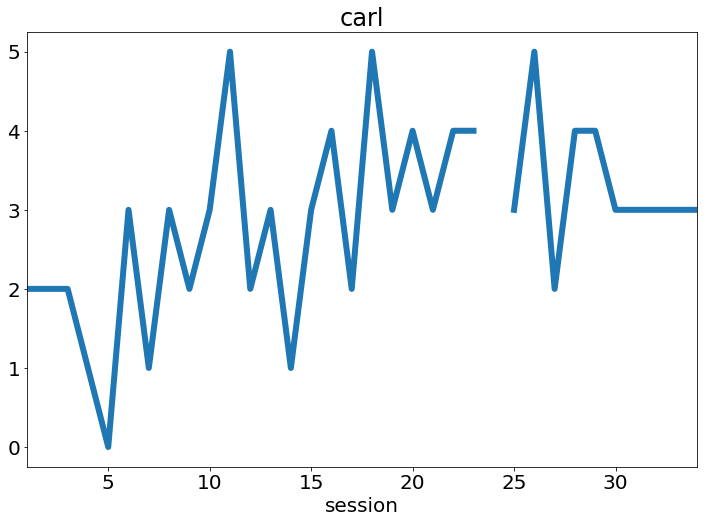

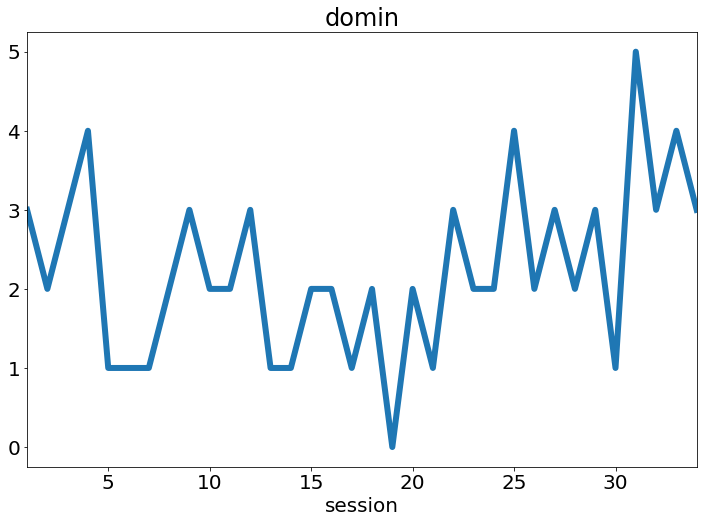

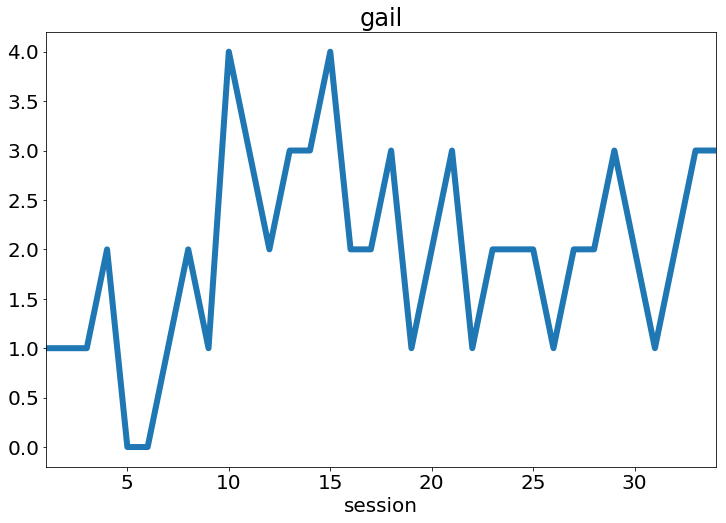

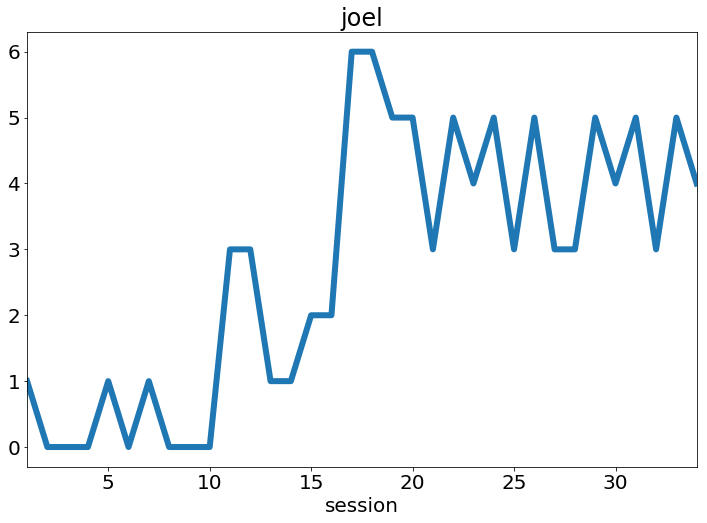

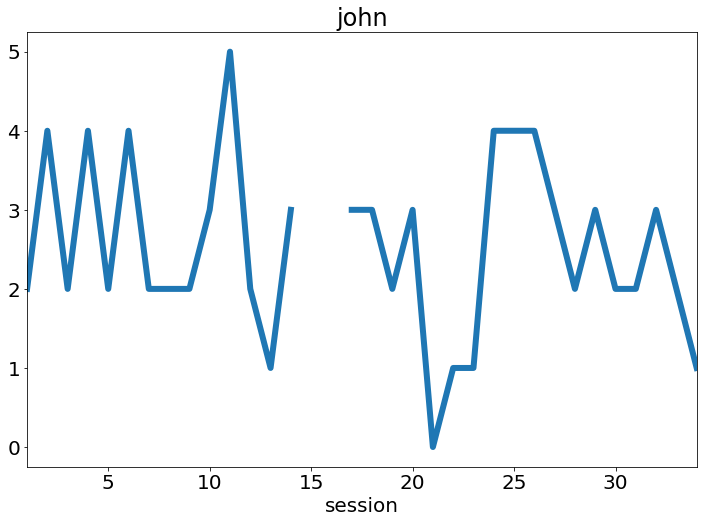

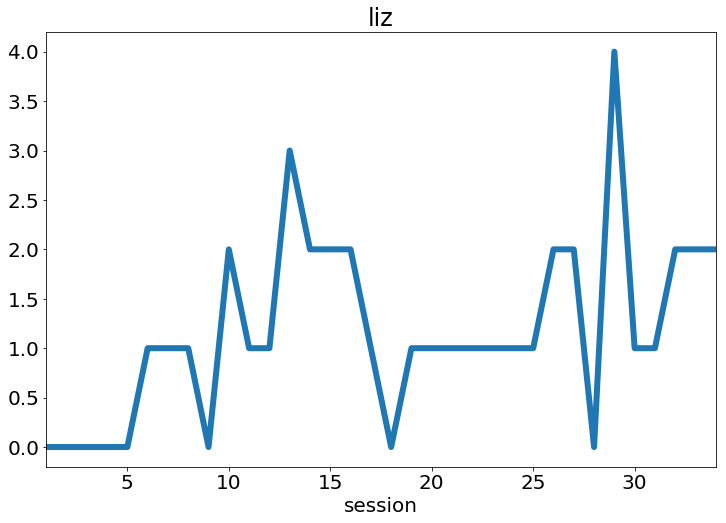

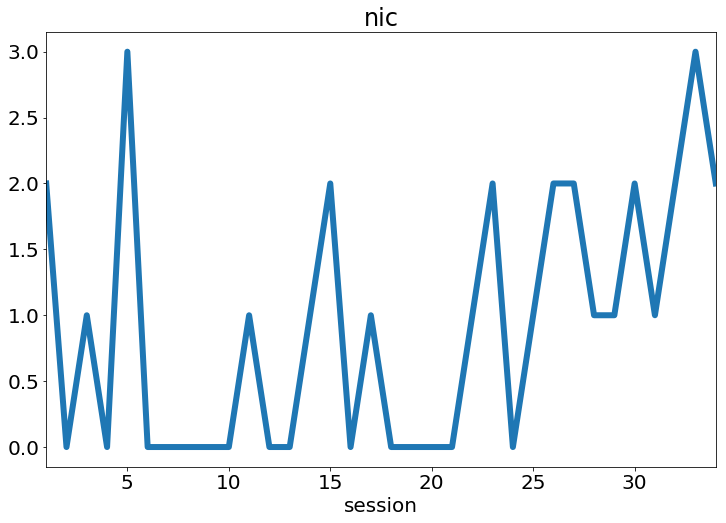

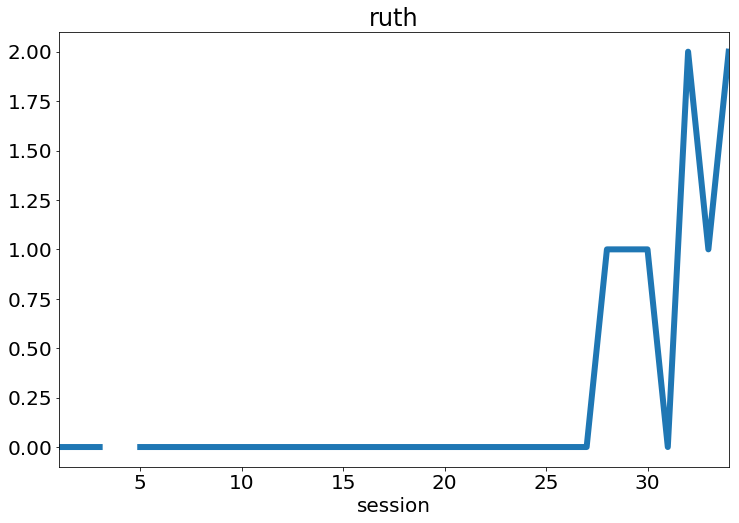

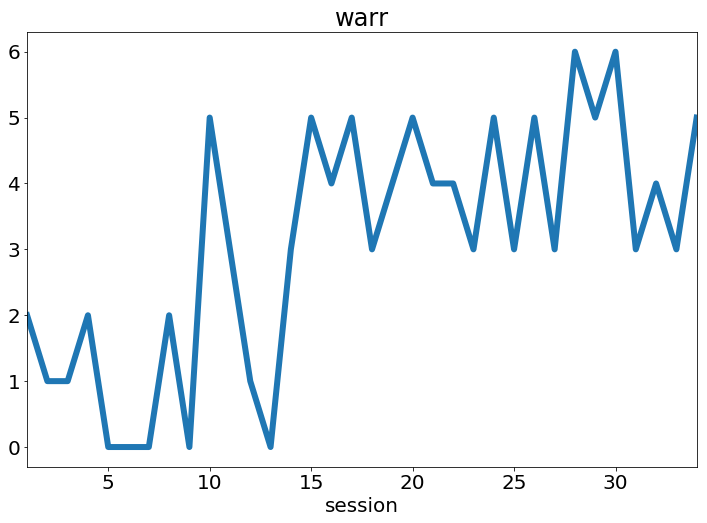

In [112]:
d = stt[2].unstack('session').T
for child in d.columns:
    d[child].plot(title=child)
    plt.show()

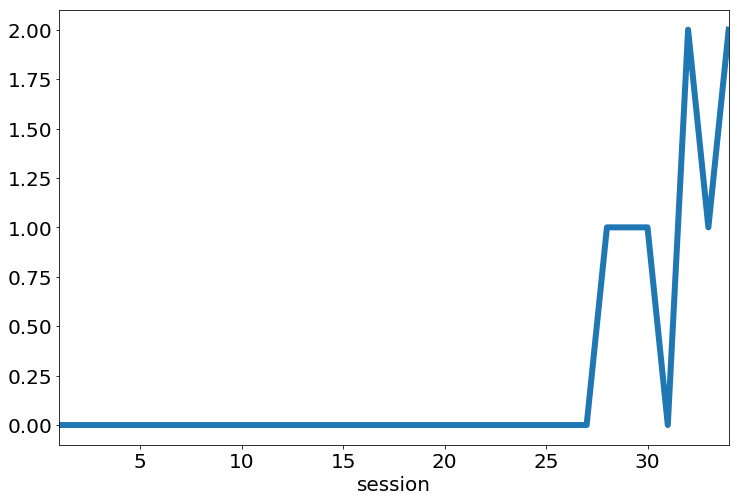

In [80]:
stt[2, 'ruth'].plot();

In [130]:
tops = (
    grams[grams.gramsize.eq(2) & grams.corpus.eq('john')]
    .groupby(['session', 'speaker'])
    .apply(get_top_types)
)

In [134]:
tops[1]

speaker                 
CHI      in the             18
         the boat           11
         it stuck            8
         it 's               8
         do horsie           7
         Mummy in            7
         a boat              6
         byebye starfish     6
         blue spider         5
         a starfish          5
         the dolly           5
MOT      it 's              36
         's a               28
         shall we           27
         that 's            26
         you want           20
         in the             17
         draw a             16
         is it              16
         on the             16
         what 's            16
Name: ngram, dtype: int64

In [135]:
tops[2]

speaker              
CHI      's the          12
         it 's           12
         there 's        11
         do it            9
         's a             8
         Mummy do         8
         what 's          6
         this is          6
         where 's         6
         dumper truck     5
         blue digger      5
         it stuck         5
MOT      that 's         48
         it 's           45
         's a            30
         what 's         23
         shall we        18
         very good       18
         there 's        15
         on the          14
         's right        12
         this one        11
         in the          11
         you put         11
Name: ngram, dtype: int64

# Shared Types 2

## How many of Speaker A's Top Tokens are also used by Speaker B

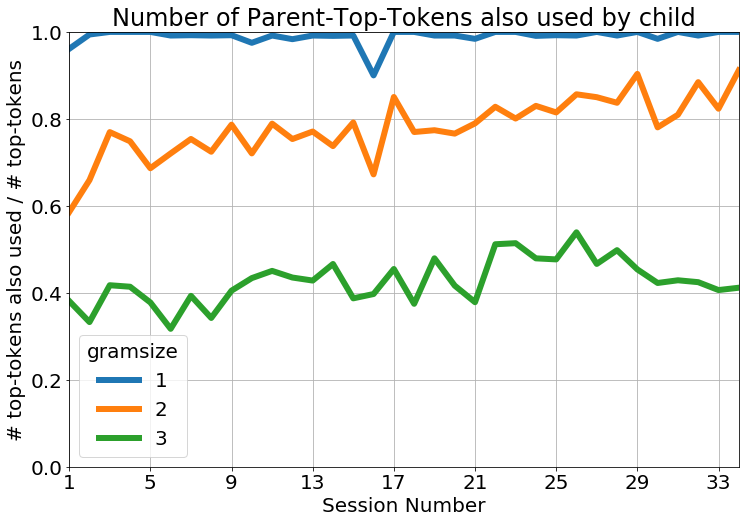

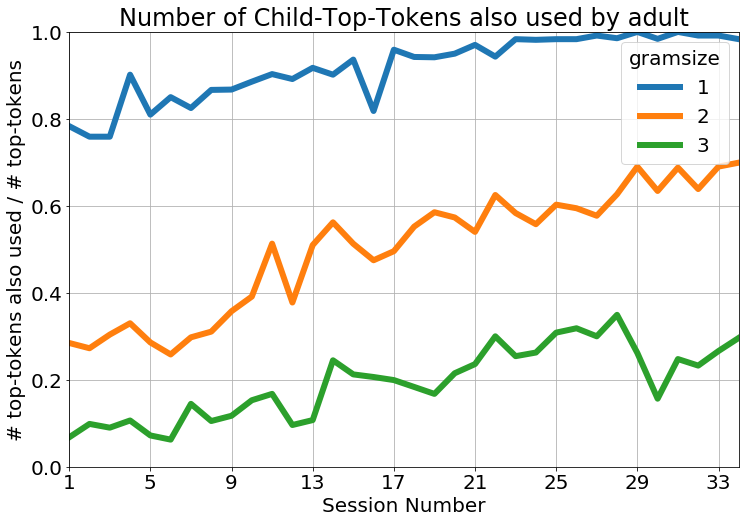

In [41]:
def num_nonunique_top_types_for_speakers(df, target, partner):
    top_types = get_top_types(df[df.speaker.eq(target)])
    other_corpus = df[df.speaker.eq(partner)].ngram
    num_shared = len(np.intersect1d(top_types.index, other_corpus))
    if num_shared == 0:
        return 0
    return  num_shared / len(top_types)

def ratio_nonunique_top_types(df):
    """ df contains data from both speakers """
    chi = num_nonunique_top_types_for_speakers(df, 'CHI', 'MOT')
    mot = num_nonunique_top_types_for_speakers(df, 'MOT', 'CHI')
    return pd.Series({'chi': chi, 'mot': mot})

st2 = (
    grams.groupby(['gramsize', 'corpus', 'session'])
    .apply(num_nonunique_top_types)
)
ratios = st2.mean(level=['gramsize', 'session']).unstack('gramsize')
ratios.chi.plot()
vvv_format(title="Number of Parent-Top-Tokens also used by child", legend=False, 
           ylabel='# top-tokens also used / # top-tokens')
ratios.mot.plot()
vvv_format(title="Number of Child-Top-Tokens also used by adult", legend=False,
           ylabel='# top-tokens also used / # top-tokens')

In [ ]:
def uniques(df):
    chi = df[df.speaker.eq('CHI')].ngram.value_counts()
    mot = df[df.speaker.eq('MOT')].ngram.value_counts()
    top_chi = top_ten(chi).index
    top_mot = top_ten(mot).index
    
    common = np.intersect1d(chi.index, mot.index)
    top_shared = np.intersect1d(top_ten(chi).index, top_ten(mot).index)
    d = {'top_chi_unique': len(np.setdiff1d(top_chi, mot.index)),
         'top_mot_unique': len(np.setdiff1d(top_mot, chi.index)),
         'top_chi_types': len(top_chi),
         'top_mot_types': len(top_mot),
         'mot_types': len(mot),
         'chi_types': len(chi),
         'mot_tokens': len(df[df.speaker.eq('MOT')]),
         'chi_tokens': len(df[df.speaker.eq('CHI')]),
         'top_chi_tokens': sum(top_ten(chi)),
         'top_mot_tokens': sum(top_ten(mot))
        }
    if len(top_shared) > 0:
        d['top_chi_shared'] = len(top_shared) / len(top_chi)
        d['top_mot_shared'] = len(top_shared) / len(top_mot)
    else:
        d['top_chi_shared'] = d['top_mot_shared'] = 0
    d['top_shared'] = len(top_shared)
    d['common'] = len(common)
    return pd.Series(d)
    
c = (
    grams[grams.gramsize.eq(2)]
    .groupby(['corpus', 'session'])
    .apply(uniques)
)
x = c[['top_chi_unique', 'top_mot_unique']].mean(level='session')
x.columns = ['CHI', 'MOT']
axis = x.plot()
axis.xaxis.set_label('Session Number')
vvv_format(title="Mean number of unique bigram types in speaker's top 10 bigrams (with ties)", ylabel='Number of Types', autoscale=True)

x = c[['top_chi_shared', 'top_mot_shared']].mean(level='session')
x.columns = ['CHI', 'MOT']
axis = x.plot()
axis.xaxis.set_label('Session Number')
vvv_format(title="Mean ratio of shared bigram types to speaker's top ten bigrams (with ties)", ylabel='# shared types / # types in speaker top 10', autoscale=False)

In [ ]:
x = c[['top_shared']].mean(level='session')
axis = x.plot()
axis.xaxis.set_label('Session Number')
vvv_format(title="Mean number of shared bigram types", ylabel='# shared types', autoscale=True)

In [ ]:
c.top_chi_types.plot.box()

In [ ]:
c.top_mot_types.plot.box()

In [ ]:

means = c.mean(level='session')
(
    means[['top_chi_tokens', 'top_mot_tokens']]
    .rename(columns={'top_chi_tokens': 'chi', 'top_mot_tokens': 'mot'})
    .div(
        means[['chi_tokens', 'mot_tokens']]
        .rename(columns={'chi_tokens': 'chi', 'mot_tokens': 'mot'})
    )
).plot()

vvv_format(title="Ratio of speaker's types accounted for by their top-10")